In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings

In [2]:
# Load S&P 500 prices
sp500_prices = pd \
    .read_csv("../data/raw/tessa_sp500_prices.csv") \
    .drop(columns=['GEV', 'SOLV', 'SW']) \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)
    
# Load NCI prices
nci_prices = pd \
    .read_csv("../data/raw/tessa_nci_prices.csv") \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)

# Left join on S&P
data = pd.merge(sp500_prices, nci_prices, on="date", how="left")
data = data[data.index >= "2024-03-01"]
data = data[data.index <= "2025-02-28"]

data.head(3)

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,ZTS,ADA-USD,AVAX-USD,BTC-USD,ETH-USD,LINK-USD,LTC-USD,SOL-USD,UNI-USD,XRP-USD
date,,,,,,,,,,,,,,,,,,,,,
2024-03-01,138.101761,178.815674,172.621796,159.720001,116.250908,82.889824,376.331512,570.929993,192.052322,52.261391,...,188.806396,0.719081,42.855328,62440.632812,3435.053955,20.060907,85.084114,129.990402,0.000275,0.601890
2024-03-04,141.875565,174.277084,170.827164,158.089996,117.642548,82.861298,379.018250,567.940002,191.481812,51.278603,...,185.877625,0.771294,43.088238,68330.414062,3630.433838,20.448757,88.935455,133.194580,0.000301,0.650133
2024-03-05,143.355301,169.320511,172.863022,159.330002,116.113716,83.099022,372.271790,544.840027,186.701126,51.509846,...,183.275375,0.693490,39.500137,63801.199219,3554.964600,19.010521,82.041199,125.706711,0.000192,0.592901


In [3]:
portfolio = pd.read_csv("../data/processed/starting_portfolio_2months.csv")

In [4]:
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

For stationarity checks, I referred briefly to this paper: https://business.columbia.edu/sites/default/files-efs/pubfiles/3970/computing_efficient_frontiers.pdf section 8 

## Stationarity check on daily prices

In [5]:
def check_stationarity_price(data: pd.DataFrame) -> dict:
    """
    Perform Augmented Dickey-Fuller (ADF) test on all asset price series in the dataset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.

    Returns:
        data (pd.DataFrame): DataFrame with asset names and their stationarity status (1 = stationary, 0 = non-stationary).
    """
    results = {"Asset": [], "Stationary": []}

    for asset in data.columns:
        series = data[asset].dropna()
        result = adfuller(series)
        p_value = result[1]
        
        # Stationary if p-value < 0.05
        results["Asset"].append(asset)
        results["Stationary"].append(1 if p_value < 0.05 else 0)

    # Convert dictionary to DataFrame
    results_df = pd.DataFrame(results)

    return results_df


In [6]:
results_price = check_stationarity_price(data)
(results_price["Stationary"] == 0).sum()

488

In [7]:
def plot_daily_price(data: pd.DataFrame, asset_name: str):
    """
    Plot the daily price for a specific asset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.
        asset_name (str): The asset name (column) to plot returns for.
    """
    series_asset = data[asset_name].dropna()
    result_asset = adfuller(series_asset)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(series_asset, label=f'Daily Price - {asset_name}')

    # Set title and labels
    ax.set_title(f'Daily Price of {asset_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Price')

    # Format x-axis to show months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM

    ax.legend()
    ax.grid(True)

    plt.savefig(f"../figures/{asset_name}_prices.png", dpi=300)  

    plt.show()

    print(result_asset[1])


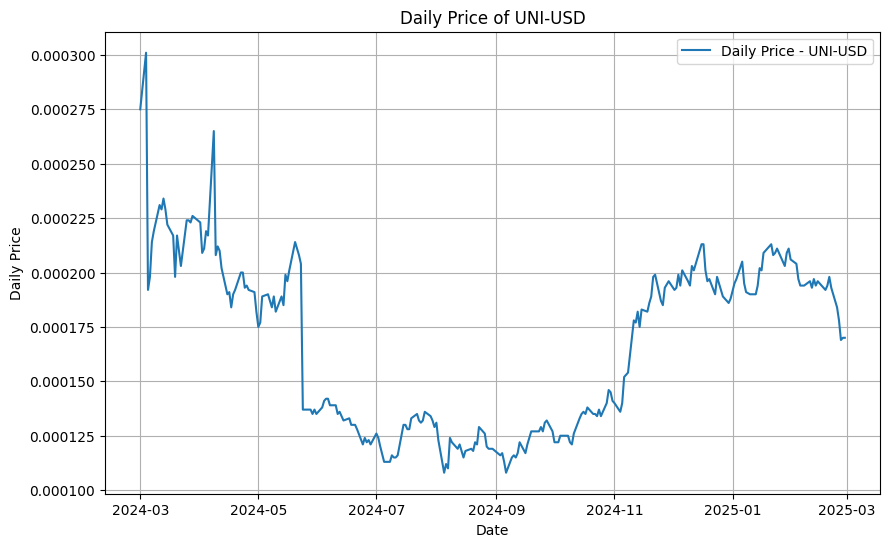

0.00924690601369158


In [9]:
plot_daily_price(data, 'UNI-USD')

## Stationarity check on daily returns 

In [10]:
def check_stationarity_all(data: pd.DataFrame) -> dict:
    """
    Perform Augmented Dickey-Fuller (ADF) test on daily returns of each asset 

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.

    Returns:
        data (pd.DataFrame): DataFrame with asset names and their stationarity status (1 = stationary, 0 = non-stationary).
    """
    results = {"Asset": [], "Stationary": []}
    daily_returns = data.pct_change()

    for asset in data.columns:
        series = daily_returns[asset].dropna()
        result = adfuller(series)
        p_value = result[1]
        
        # Stationary if p-value < 0.05
        results["Asset"].append(asset)
        results["Stationary"].append(1 if p_value < 0.05 else 0)

    # Convert dictionary to DataFrame
    results_df = pd.DataFrame(results)

    return results_df


In [11]:
# Run stationarity check for all assets
results = check_stationarity_all(data)
results

/var/folders/xx/r8ly5z917sl1cyljnn77j7z00000gn/T/ipykernel_39900/13107863.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change()


,Asset,Stationary
0,A,1
1,AAPL,1
2,ABBV,1
3,ABNB,1
4,ABT,1
...,...,...
502,LINK-USD,1
503,LTC-USD,1
504,SOL-USD,1
505,UNI-USD,1


In [12]:
(results["Stationary"] == 0).sum()

0

In [18]:
def plot_daily_returns(data: pd.DataFrame, asset_name: str):
    """
    Plot the daily returns for a specific asset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.
        asset_name (str): The asset name (column) to plot returns for.
    """
    # Calculate daily returns
    daily_returns = data.pct_change()

    series_asset = daily_returns[asset_name].dropna()
    result_asset = adfuller(series_asset)

    mean_value = series_asset.mean()
    variance_value = series_asset.var()

    print("Mean:", mean_value)
    print("Variance:", variance_value)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(series_asset, label=f'Daily Return - {asset_name}')

    # Set title and labels
    ax.set_title(f'Daily Return of {asset_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Return')

    ax.set_ylim(-0.15, 0.15)
    
    # Format x-axis to show months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM

    ax.legend()
    ax.grid(True)

    plt.savefig(f"../figures/{asset_name}_returns.png", dpi=300)

    plt.show()

    print(result_asset[1])


/var/folders/xx/r8ly5z917sl1cyljnn77j7z00000gn/T/ipykernel_39900/4095784294.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change()


Mean: 0.0007946925453571045
Variance: 0.00022598414845309976


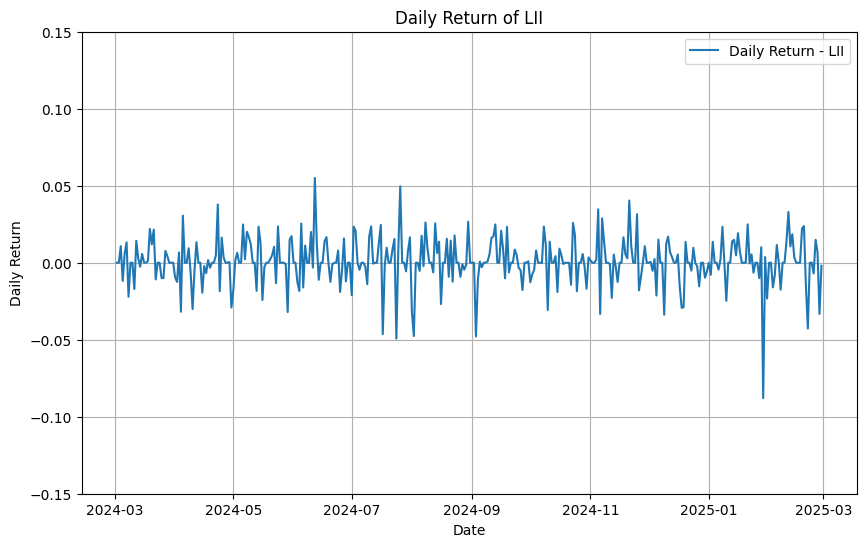

0.0


In [20]:
plot_daily_returns(data, 'LII')

## Time series plots / EDA

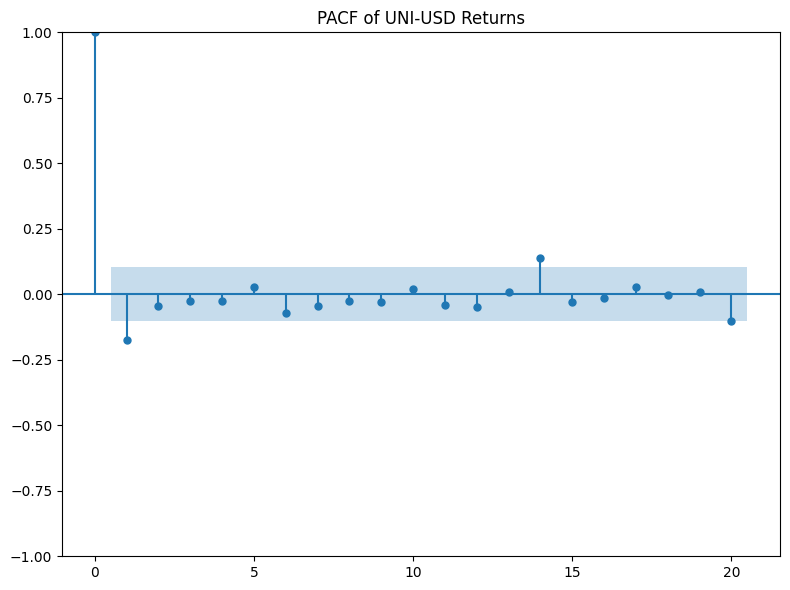

In [16]:
# Plot ACF and PACF
#fig, ax = plt.subplots(2, 1, figsize=(12, 8))

fig, ax = plt.subplots(figsize=(8, 6))

daily_returns = data['UNI-USD'].pct_change().dropna()

#plot_acf(daily_returns, ax=ax[0], lags=0)
#ax[0].set_title("ACF of UNI-USD Returns")

plot_pacf(daily_returns, ax=ax, lags=20)
ax.set_title("PACF of UNI-USD Returns")

plt.tight_layout()
#plt.savefig("../figures/UNI-USD_acf_pacf.png", dpi=300)  
plt.show()

## Mean, Variance, Kurtosis 

In [19]:
def calculate_stats(data, portfolio):
    results = []
    
    for asset in portfolio["asset"]:
        #print(f"analysing {asset}")
        series = data[asset].pct_change().dropna()
        
        stats = {
                    "asset": asset,
                    "mean": series.mean(),
                    "variance": series.var(),
                    "kurtosis": series.kurt()
                }
        results.append(stats)   
    return pd.DataFrame(results)

In [20]:
warnings.filterwarnings("ignore")

stats_df = calculate_stats(data, portfolio)
stats_df

,asset,mean,variance,kurtosis
0,AES,-0.000448,0.000437,6.581982
1,AKAM,-0.000657,0.000372,56.429741
2,ODFL,-0.000452,0.000329,9.336652
3,TSLA,0.001578,0.001160,6.882141
4,STZ,-0.000815,0.000202,56.740830
5,INTC,-0.001217,0.000846,20.368391
6,DECK,0.000042,0.000498,24.949592
7,BLDR,-0.000735,0.000517,14.411662
8,CBRE,0.001260,0.000196,9.582175
9,MCHP,-0.000786,0.000439,3.974089


## AR Models

Modelling fitting using Box-Jenkins procedure

In [11]:
def fit_best_arma(series):
    """ Fit AR model and return the best based on BIC """
    best_bic = np.inf  
    best_aic = np.inf
    best_order = None
    best_model = None
    
    for p in range(1, 4):  # Grid search
        try:
            model = ARIMA(series, order=(p, 0, 0)).fit()
            if model.bic < best_bic:
                best_bic = model.bic
                best_aic = model.aic
                best_order = (p, 0, 0)
                best_model = model

        except:
            continue
    
    return best_model, best_order, best_bic, best_aic

In [12]:
def analyze_assets(data, portfolio):
    """ Apply Box-Jenkins methodology to all assets """
    results = []
    
    for asset in portfolio["asset"]:
        print(f"analysing {asset}")
        series = data[asset].pct_change().dropna()
        best_model, best_order, best_bic, best_aic = fit_best_arma(series)
        
        if best_model:
            coef = best_model.params.to_dict()  # Extract model coefficients
            results.append({
                "Asset": asset, 
                "Best Model": best_order, 
                "BIC": best_bic,
                "AIC": best_aic,
                **coef  # Expand coefficients into individual columns
            })
    
    return pd.DataFrame(results)

In [13]:
warnings.filterwarnings("ignore")

results_df = analyze_assets(data, portfolio)

analysing AES
analysing AKAM
analysing ODFL
analysing TSLA
analysing STZ
analysing INTC
analysing DECK
analysing BLDR
analysing CBRE
analysing MCHP
analysing PHM
analysing CSGP
analysing MOH
analysing PLD
analysing LII
analysing GS
analysing LRCX
analysing MCO
analysing PCG
analysing CARR
analysing GM
analysing DXCM
analysing ADI
analysing SOL-USD
analysing LINK-USD
analysing XRP-USD
analysing ADA-USD
analysing LTC-USD
analysing ETH-USD
analysing UNI-USD


In [14]:
results_df

,Asset,Best Model,BIC,AIC,const,ar.L1,sigma2,ar.L2,ar.L3
0,AES,"(1, 0, 0)",-1766.383129,-1778.074591,-0.000457,-0.037837,0.000435,NaN,NaN
1,AKAM,"(1, 0, 0)",-1824.557795,-1836.249257,-0.000660,0.000063,0.000371,NaN,NaN
2,ODFL,"(1, 0, 0)",-1869.853408,-1881.544869,-0.000455,-0.022480,0.000328,NaN,NaN
3,TSLA,"(1, 0, 0)",-1410.807299,-1422.498760,0.001576,0.012920,0.001156,NaN,NaN
4,STZ,"(1, 0, 0)",-2047.738943,-2059.430404,-0.000819,-0.037615,0.000201,NaN,NaN
5,INTC,"(1, 0, 0)",-1526.066814,-1537.758276,-0.001218,0.031652,0.000842,NaN,NaN
6,DECK,"(1, 0, 0)",-1719.212061,-1730.903523,0.000040,-0.033131,0.000496,NaN,NaN
7,BLDR,"(1, 0, 0)",-1705.301083,-1716.992545,-0.000737,-0.031178,0.000515,NaN,NaN
8,CBRE,"(1, 0, 0)",-2059.487814,-2071.179275,0.001259,0.072816,0.000195,NaN,NaN
9,MCHP,"(1, 0, 0)",-1765.177843,-1776.869305,-0.000790,-0.044913,0.000437,NaN,NaN


In [10]:
results_df['Best Model'].value_counts()

Best Model
(1, 0, 0)    29
(3, 0, 0)     1
Name: count, dtype: int64

In [18]:
results_df.to_csv("../data/processed/ar_model_2months.csv", index=False)